# Imports
***

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from pylab import rcParams

%matplotlib inline
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 20,10
rcParams['font.size'] = 30
sns.set()
np.random.seed(8)

from scipy.optimize import minimize
import scipy.stats as stats
import pymc3 as pm3
import numdifftools as ndt
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

# Loading and visualizing data
***

In [2]:
header_list = ["spec_name", "impl_name", "set_size", "edge_prob", "policy_size", "spec_len", "rego_lines_of_code", "error_rate", "edge_number", "comp_cum_time", "result"]
df = pd.read_csv("equivalence.dat", sep=';', usecols=[0,1,2,3,4,5,6,7,8,9,10], names=header_list)

chunks = pd.read_csv("equivalence.dat", sep=';', usecols=[0,1,2,3,4,5,6,7,8,9,10], names=header_list, chunksize=50000)
slim_data = []
for chunk in chunks:
    chunk["comp_cum_time"] *= 1000
    slim_data.append(chunk)
df = pd.concat(slim_data)

# Seconds to Milliseconds
#df["comp_cum_time"] *= 1000

df

,spec_name,impl_name,set_size,edge_prob,policy_size,spec_len,rego_lines_of_code,error_rate,edge_number,comp_cum_time,result
0,workflow-specs/randomly-generated/10-set-1-0-e...,impl-metagraph-generators/generated-from-rando...,10,1.0,1,24,332,0.0,35,0.180,True
1,workflow-specs/randomly-generated/10-set-1-0-e...,impl-metagraph-generators/generated-from-rando...,10,1.0,1,24,332,0.0,35,0.294,True
2,workflow-specs/randomly-generated/10-set-1-0-e...,impl-metagraph-generators/generated-from-rando...,10,1.0,1,24,332,0.0,35,0.207,True
3,workflow-specs/randomly-generated/10-set-1-0-e...,impl-metagraph-generators/generated-from-rando...,10,1.0,1,24,332,0.0,35,0.275,True
4,workflow-specs/randomly-generated/10-set-1-0-e...,impl-metagraph-generators/generated-from-rando...,10,1.0,1,24,332,0.0,35,0.140,True
...,...,...,...,...,...,...,...,...,...,...,...
1079995,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,1,250,12886,0.7,378,3.748,False
1079996,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,1,250,12886,0.7,378,3.192,False
1079997,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,1,250,12886,0.7,378,3.259,False
1079998,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,1,250,12886,0.7,378,2.992,False


# Removing outliers and harmonizing sample size
***

In [3]:
# All values of predictors
set_sizes = sorted(df.set_size.unique())
policy_sizes = sorted(df.policy_size.unique())
error_rates = sorted(df.error_rate.unique())


# Removing 0.7 error rates values from data
#error_rates = error_rates[:-1]


print("Used values:")
print("Set sizes: {}".format(set_sizes))
print("Policy sizes: {}".format(policy_sizes))
print("Error rates: {}".format(error_rates))
print("")


# Making list of DFs by predictors
preds_df_list = []
labels = []
for set_size in set_sizes:
    for policy_size in policy_sizes:
        for error_rate in error_rates:
            print("DF parameters: {} {} {}".format(set_size, policy_size, error_rate))
            labels.append("{} {} {}".format(set_size, policy_size, error_rate))
            preds_df_list.append(df[(df.set_size == set_size) & (df.policy_size == policy_size) & (df.error_rate == error_rate)])
print("\n")


print("Unmodified DF shapes")
for pred_df in preds_df_list:
    print(pred_df.shape)
print("\n")


# Removing outliers in DFs
new_preds_df_list = []
for pred_df in preds_df_list: # Remove all values with Z-score > 3
    new_preds_df_list.append( pred_df[np.abs(pred_df.comp_cum_time-pred_df.comp_cum_time.mean()) <= (3*pred_df.comp_cum_time.std())] )
preds_df_list = new_preds_df_list


# Print DF shapes to check sample sizes, put them in list
preds_df_list_sample_sizes = []
print("No outliers DF shapes")
for pred_df in preds_df_list:
    print(pred_df.shape)
    preds_df_list_sample_sizes.append(pred_df.shape[0])
print("\n")

minimum_sample_size = min(preds_df_list_sample_sizes)
print("Minimum common sample size: {}".format(minimum_sample_size))

# Make sample sizes equal
new_preds_df_list = []
for pred_df in preds_df_list:
    new_preds_df_list.append(pred_df.head(minimum_sample_size))
preds_df_list = new_preds_df_list


# Check new DF shapes
print("Modified DF shapes")
for pred_df in preds_df_list:
    print(pred_df.shape)
print("\n")

Used values:
Set sizes: [10, 20, 30, 50, 100]
Policy sizes: [1, 2]
Error rates: [0.0, 0.2, 0.4, 0.7]

DF parameters: 10 1 0.0
DF parameters: 10 1 0.2
DF parameters: 10 1 0.4
DF parameters: 10 1 0.7
DF parameters: 10 2 0.0
DF parameters: 10 2 0.2
DF parameters: 10 2 0.4
DF parameters: 10 2 0.7
DF parameters: 20 1 0.0
DF parameters: 20 1 0.2
DF parameters: 20 1 0.4
DF parameters: 20 1 0.7
DF parameters: 20 2 0.0
DF parameters: 20 2 0.2
DF parameters: 20 2 0.4
DF parameters: 20 2 0.7
DF parameters: 30 1 0.0
DF parameters: 30 1 0.2
DF parameters: 30 1 0.4
DF parameters: 30 1 0.7
DF parameters: 30 2 0.0
DF parameters: 30 2 0.2
DF parameters: 30 2 0.4
DF parameters: 30 2 0.7
DF parameters: 50 1 0.0
DF parameters: 50 1 0.2
DF parameters: 50 1 0.4
DF parameters: 50 1 0.7
DF parameters: 50 2 0.0
DF parameters: 50 2 0.2
DF parameters: 50 2 0.4
DF parameters: 50 2 0.7
DF parameters: 100 1 0.0
DF parameters: 100 1 0.2
DF parameters: 100 1 0.4
DF parameters: 100 1 0.7
DF parameters: 100 2 0.0
DF pa

# Merge all data back together
***

In [4]:
merged_df = pd.DataFrame()
for pred_df in preds_df_list:
    merged_df = merged_df.append(pred_df)

df = merged_df

df

,spec_name,impl_name,set_size,edge_prob,policy_size,spec_len,rego_lines_of_code,error_rate,edge_number,comp_cum_time,result
0,workflow-specs/randomly-generated/10-set-1-0-e...,impl-metagraph-generators/generated-from-rando...,10,1.0,1,24,332,0.0,35,0.180,True
1,workflow-specs/randomly-generated/10-set-1-0-e...,impl-metagraph-generators/generated-from-rando...,10,1.0,1,24,332,0.0,35,0.294,True
2,workflow-specs/randomly-generated/10-set-1-0-e...,impl-metagraph-generators/generated-from-rando...,10,1.0,1,24,332,0.0,35,0.207,True
3,workflow-specs/randomly-generated/10-set-1-0-e...,impl-metagraph-generators/generated-from-rando...,10,1.0,1,24,332,0.0,35,0.275,True
4,workflow-specs/randomly-generated/10-set-1-0-e...,impl-metagraph-generators/generated-from-rando...,10,1.0,1,24,332,0.0,35,0.140,True
...,...,...,...,...,...,...,...,...,...,...,...
944840,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23781,0.7,614,6.621,False
944841,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23781,0.7,614,7.751,False
944842,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23781,0.7,614,6.972,False
944843,workflow-specs/randomly-generated/100-set-1-0-...,impl-metagraph-generators/generated-from-rando...,100,1.0,2,250,23781,0.7,614,7.958,False


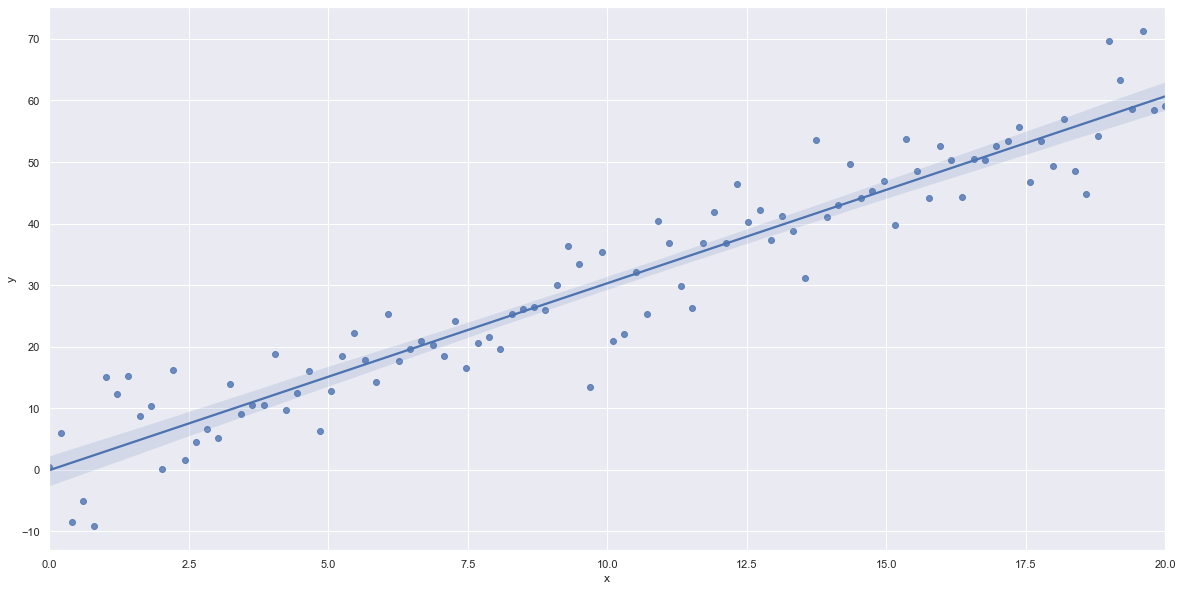

In [17]:
# generate data
N = 100
x = np.linspace(0,20,N)
e = np.random.normal(loc = 0.0, scale = 5.0, size = N)
y = 3*x + e

df_t = pd.DataFrame({'y':y, 'x':x})
df_t['constant'] = 1

sns.regplot(df_t.x, df_t.y);

In [18]:
# split features and target
X = df_t[['constant', 'x']]# fit model and summarize
sm.OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     972.0
Date:                Thu, 12 Nov 2020   Prob (F-statistic):           1.14e-52
Time:                        00:29:35   Log-Likelihood:                -314.58
No. Observations:                 100   AIC:                             633.2
Df Residuals:                      98   BIC:                             638.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -0.0587      1.128     -0.052      0.959      -2.296       2.179
x              3.0367      0.097     31.177      0.000       2.843       3.230
==============================================================================
Omnibus:                        0.200   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.905   Jarque-Bera (JB):                0.043
Skew:                          -0.048   Prob(JB):                        0.979
Kurtosis:                       3.034   Cond. No.                         23.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
# define likelihood function
def MLERegression(params):
    intercept, beta, sd = params[0], params[1], params[2] # inputs are guesses at our parameters
    yhat = intercept + beta*x # predictions

    # next, we flip the Bayesian question
    # compute PDF of observed values normally distributed around mean (yhat)
    # with a standard deviation of sd
    negLL = -np.sum( stats.norm.logpdf(y, loc=yhat, scale=sd) )# return negative LL
    return(negLL)

In [21]:
guess = np.array([5,5,2])
guess

array([5, 5, 2])

In [26]:
results = minimize(MLERegression, guess, method = 'Nelder-Mead', options={'disp': True})
print("")
print(results)

Optimization terminated successfully.
         Current function value: 314.578252
         Iterations: 105
         Function evaluations: 182

 final_simplex: (array([[-0.05875208,  3.03668209,  5.62286058],
       [-0.05868674,  3.03667778,  5.62286868],
       [-0.05879034,  3.03667855,  5.62288982],
       [-0.05876173,  3.03668613,  5.62289768]]), array([314.57825248, 314.57825248, 314.57825248, 314.57825249]))
           fun: 314.5782524800341
       message: 'Optimization terminated successfully.'
          nfev: 182
           nit: 105
        status: 0
       success: True
             x: array([-0.05875208,  3.03668209,  5.62286058])


In [34]:
# drop results into df and round to match statsmodels
resultsdf = pd.DataFrame({'coef':results['x']})
resultsdf.index=['constant','x','sigma']   
np.round(resultsdf, 4)

,coef
constant,-0.0588
x,3.0367
sigma,5.6229


In [29]:
df_t = pd.DataFrame({'y':df["comp_cum_time"], 'x':df["edge_number"]})
df_t['constant'] = 1

df_t

,y,x,constant
0,0.180,35,1
1,0.294,35,1
2,0.207,35,1
3,0.275,35,1
4,0.140,35,1
...,...,...,...
944840,6.621,614,1
944841,7.751,614,1
944842,6.972,614,1
944843,7.958,614,1


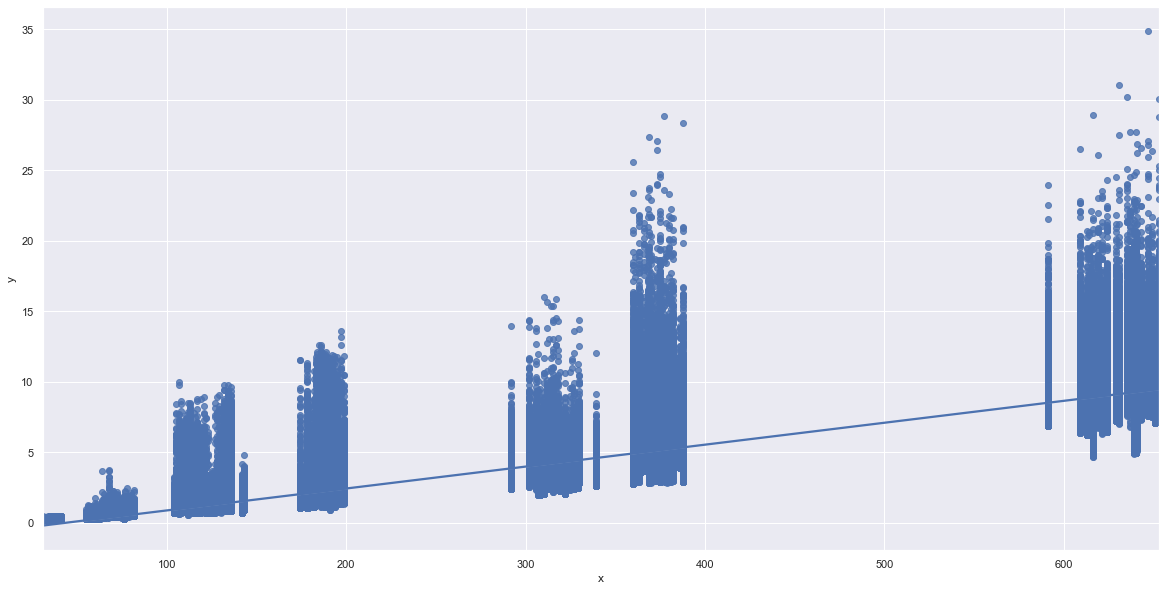

In [30]:
sns.regplot(df_t.x, df_t.y);

In [31]:
# define likelihood function
def MLELogRegression(params):
    intercept, beta, sd = params[0], params[1], params[2] # inputs are guesses at our parameters
    yhat = intercept + beta*x*np.log(x) # predictions

    # next, we flip the Bayesian question
    # compute PDF of observed values normally distributed around mean (yhat)
    # with a standard deviation of sd
    negLL = -np.sum( stats.norm.logpdf(y, loc=yhat, scale=sd) )# return negative LL
    return(negLL)

In [32]:
guess = np.array([0,0.040,2])
guess

array([0.  , 0.04, 2.  ])

In [36]:
results = minimize(MLELogRegression, guess, method = 'Nelder-Mead', options={'disp': True})
print("")
print(results)


 final_simplex: (array([[0.00000000e+00, 4.00000000e-02, 2.00000000e+00],
       [1.88079096e-40, 4.00000000e-02, 2.00000000e+00],
       [0.00000000e+00, 4.00000000e-02, 2.00000000e+00],
       [0.00000000e+00, 4.00000000e-02, 2.00000000e+00]]), array([nan, nan, nan, nan]))
           fun: nan
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 604
           nit: 121
        status: 1
       success: False
             x: array([0.  , 0.04, 2.  ])
